# **Mô tả vấn đề**

## **1. Thiết lập vấn đề**


# **2. Cách thực hiện**
Mô tả này đi qua việc thực hiên một bộ giải cho từng bước được mô tả ở trên

### *2.1. Import các thư viện cần thiết*

In [8]:
import deepxde as dde
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

# Thiết lập độ chính xác
dde.config.set_default_float("float64")

# Đặt seed để tái lập
np.random.seed(1234)
tf.random.set_seed(1234)

# Định nghĩa các tham số vật lý
L_x, L_y = 1000, 1000  # Kích thước vỉa (m)
h = 10  # Chiều dày vỉa (m)
A = L_y * h  # Diện tích mặt cắt (m²)
phi = 0.2  # Độ rỗng đồng nhất
k = 100e-15  # Độ thấm đồng nhất (m²)
v = 0.5  # Vận tốc Darcy (m/day)
M = 1.0  # Tỷ số độ nhớt (mu_o / mu_w)
mu_w = 1e-3  # Độ nhớt nước (Pa.s)
mu_o = M * mu_w  # Độ nhớt dầu (Pa.s)
Q_w_inj = 200  # Lưu lượng bơm ép nước (m³/day)
Q_prod = 200  # Lưu lượng khai thác (m³/day)
t_simulate = 7000  # Thời gian mô phỏng (days)
well_radius = 10  # Bán kính vùng giếng (m)

"""# Định nghĩa hàm phân đoạn nước (fractional flow)
def f_w(Sw):
    kr_w = Sw ** 2  # Độ thấm tương đối nước
    kr_o = (1 - Sw) ** 2  # Độ thấm tương đối dầu
    return kr_w / (kr_w + (kr_o / M))

# Tính Sw* và sigma cho hàm f_w_tilde
Sw_star = np.sqrt(1 / (1 + 1 / M))
sigma = f_w(Sw_star) / Sw_star

def f_w_tilde(Sw):
    Sw = tf.cast(Sw, tf.float64)
    return tf.where(Sw < Sw_star, sigma * Sw, f_w(Sw))"""

# Định nghĩa PDE cho độ bão hòa nước
def pde(x, Sw):
    Sw = tf.cast(Sw, tf.float64)
    t = x[:, 2:3]  # thời gian (3rd dimension)

    # Đạo hàm thời gian của Sw
    dSw_dt = dde.grad.jacobian(Sw, x, i=0, j=2)

    # Gradient áp suất (hằng số)
    grad_P = tf.constant([-1 / L_x, -1 / L_y], dtype=tf.float64)

    # Độ thấm tương đối nước, thêm giới hạn để tránh nan
    kr_w = tf.clip_by_value(Sw ** 2, 1e-10, 1.0)

    # Gradient của Sw
    dSw_dx = dde.grad.jacobian(Sw, x, i=0, j=0)  # dSw/dx
    dSw_dy = dde.grad.jacobian(Sw, x, i=0, j=1)  # dSw/dy

    # Gradient của kr_w = 2 * Sw * grad(Sw)
    grad_Sw = tf.concat([dSw_dx, dSw_dy], axis=1)
    grad_kr_w = 2 * tf.clip_by_value(Sw, 1e-10, 1.0) * grad_Sw

    # Divergence của q_w = -k / mu_w * (grad_kr_w . grad_P)
    div_q_w = -k / mu_w * tf.reduce_sum(grad_kr_w * grad_P, axis=1, keepdims=True)

    # Phương trình bảo toàn khối lượng cho nước
    return phi * dSw_dt + div_q_w

# Định nghĩa miền không gian-thời gian
geom = dde.geometry.Rectangle([0, 0], [L_x, L_y])
timedomain = dde.geometry.TimeDomain(0, t_simulate)
geomtime = dde.geometry.GeometryXTime(geom, timedomain)

# Điều kiện ban đầu: Sw(x, y, 0) = 0
def initial_condition(x):
    return tf.zeros_like(x[:, 0:1], dtype=tf.float64)

ic = dde.icbc.IC(geomtime, initial_condition, lambda x, on_initial: on_initial)

# Điều kiện biên cho giếng bơm ép tại (x, y) = (0, 0)
def injection_well_condition(x, on_boundary):
    return on_boundary and np.isclose(x[0], 0, atol=5) and np.isclose(x[1], 0, atol=50)

bc_injection = dde.icbc.DirichletBC(
    geomtime,
    lambda x: np.ones_like(x[:, 0:1]),
    injection_well_condition
)

# Điều kiện biên cho giếng khai thác tại (x, y) = (L_x, L_y)
def production_well_condition(x, on_boundary):
    return on_boundary and np.isclose(x[0], L_x, atol=5) and np.isclose(x[1], L_y, atol=50)

bc_production = dde.icbc.DirichletBC(
    geomtime,
    lambda x: np.zeros_like(x[:, 0:1]),
    production_well_condition
)

# Dữ liệu huấn luyện
data = dde.data.TimePDE(
    geomtime,
    pde,
    [bc_injection, bc_production, ic],
    num_domain=10000,
    num_boundary=2000,
    num_initial=2000,
    num_test=10000,
)

# Định nghĩa mạng nơ-ron
layer_size = [3] + [128] * 6 + [1]  # Input: (x, y, t)
activation = "tanh"
initializer = "Glorot normal"
net = dde.nn.FNN(layer_size, activation, initializer)

# Ép kiểu đầu ra
def output_transform(x, y):
    Sw = tf.nn.sigmoid(y)  # Đảm bảo Sw trong [0, 1]
    return Sw

net.apply_output_transform(output_transform)

# Mô hình
model = dde.Model(data, net)

# Tối ưu hóa
model.compile("adam", lr=0.0001)

# Huấn luyện với Adam trước
losshistory, train_state = model.train(iterations=10000, display_every=10)

# Chuyển sang L-BFGS để tối ưu hóa thêm
model.compile("L-BFGS")
losshistory, train_state = model.train()

Set the default float type to float64
Compiling model...
Building feed-forward neural network...
'build' took 0.051432 s

'compile' took 0.354248 s

Training model...

Step      Train loss                                  Test loss                                   Test metric
0         [5.33e-08, 4.49e-01, 1.16e-01, 1.32e-01]    [4.58e-09, 4.49e-01, 1.16e-01, 1.32e-01]    []  
10        [2.05e-08, 7.12e-02, 1.45e-01, 2.09e-02]    [7.55e-09, 7.12e-02, 1.45e-01, 2.09e-02]    []  
20        [7.20e-09, 5.38e-02, 3.70e-02, 4.03e-03]    [5.01e-09, 5.38e-02, 3.70e-02, 4.03e-03]    []  
30        [6.89e-09, 1.66e-02, 2.05e-02, 1.64e-03]    [7.29e-09, 1.66e-02, 2.05e-02, 1.64e-03]    []  
40        [7.09e-09, 8.05e-03, 8.67e-03, 8.65e-04]    [8.62e-09, 8.05e-03, 8.67e-03, 8.65e-04]    []  
50        [7.59e-09, 5.01e-03, 3.82e-03, 5.52e-04]    [1.04e-08, 5.01e-03, 3.82e-03, 5.52e-04]    []  
60        [8.67e-09, 2.99e-03, 2.64e-03, 4.10e-04]    [1.18e-08, 2.99e-03, 2.64e-03, 4.10e-04]    []  
7

### *2.11. Sau khi train mạng sử dụng* **Adam**, *chúng ta sẽ tiếp tục train sử dụng* **L-BFGS** *để đạt được sai số nhỏ hơn*

### *2.12. Vẽ đồ thị kết quả và sai số*

Saving loss history to c:\Users\User\Downloads\loss.dat ...
Saving training data to c:\Users\User\Downloads\train.dat ...
Saving test data to c:\Users\User\Downloads\test.dat ...


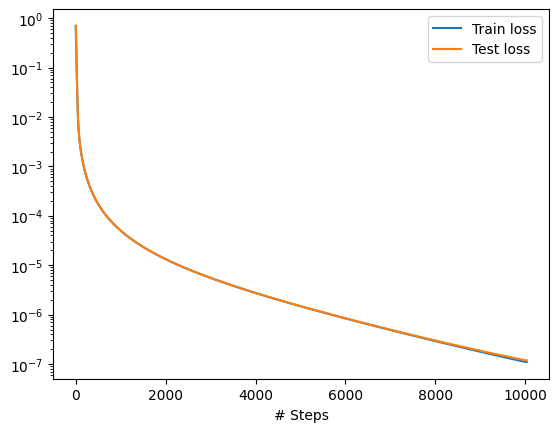

In [9]:
dde.saveplot(losshistory, train_state, issave=True, isplot=True)

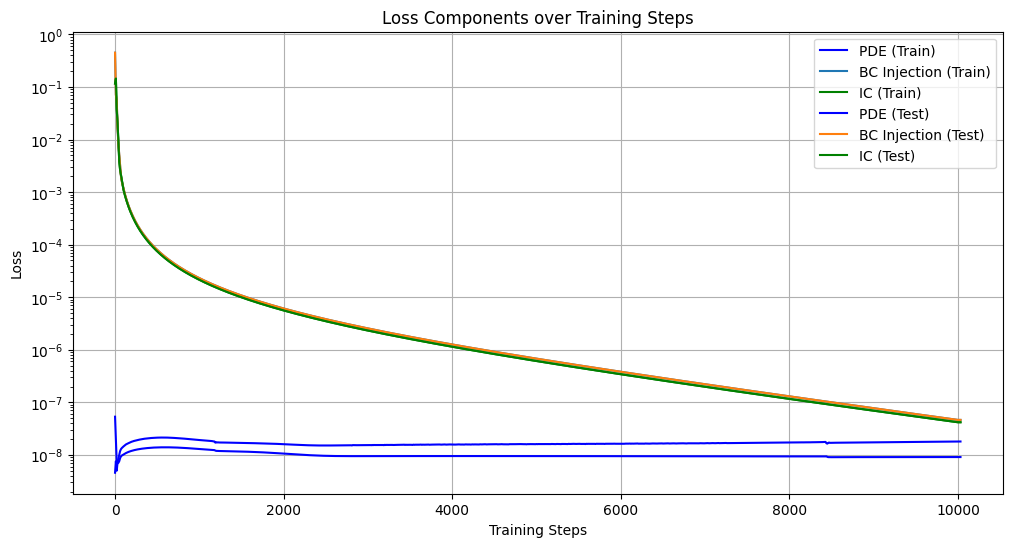

In [10]:
def visualize_loss_lines(losshistory):
    # Lấy dữ liệu từ losshistory
    steps = losshistory.steps
    train_loss = np.array(losshistory.loss_train)
    test_loss = np.array(losshistory.loss_test)

    # Tách các thành phần
    pde_train, bc_injection_train, ic_train = train_loss[:, 0], train_loss[:, 1], train_loss[:, 2]
    pde_test, bc_injection_test, ic_test = test_loss[:, 0], test_loss[:, 1], test_loss[:, 2]

    # Vẽ biểu đồ
    plt.figure(figsize=(12, 6))

    # Train loss
    plt.plot(steps, pde_train, 'b-', label='PDE (Train)')
    plt.plot(steps, bc_injection_train, label='BC Injection (Train)')
    #plt.plot(steps, bc_production_train, 'r-', label='BC Production (Train)')
    plt.plot(steps, ic_train, 'g-', label='IC (Train)')

    # Test loss
    plt.plot(steps, pde_test, 'b-', label='PDE (Test)')
    plt.plot(steps, bc_injection_test, label='BC Injection (Test)')
    #plt.plot(steps, bc_production_test, 'r-', label='BC Production (Test)')
    plt.plot(steps, ic_test, 'g-', label='IC (Test)')

    plt.xlabel('Training Steps')
    plt.ylabel('Loss')
    plt.title('Loss Components over Training Steps')
    plt.yscale('log') # Dùng thang log để thấy rõ sự giảm của loss
    plt.grid(True)
    plt.legend()
    plt.show()

# Gọi sau khi huấn luyện
visualize_loss_lines(losshistory)

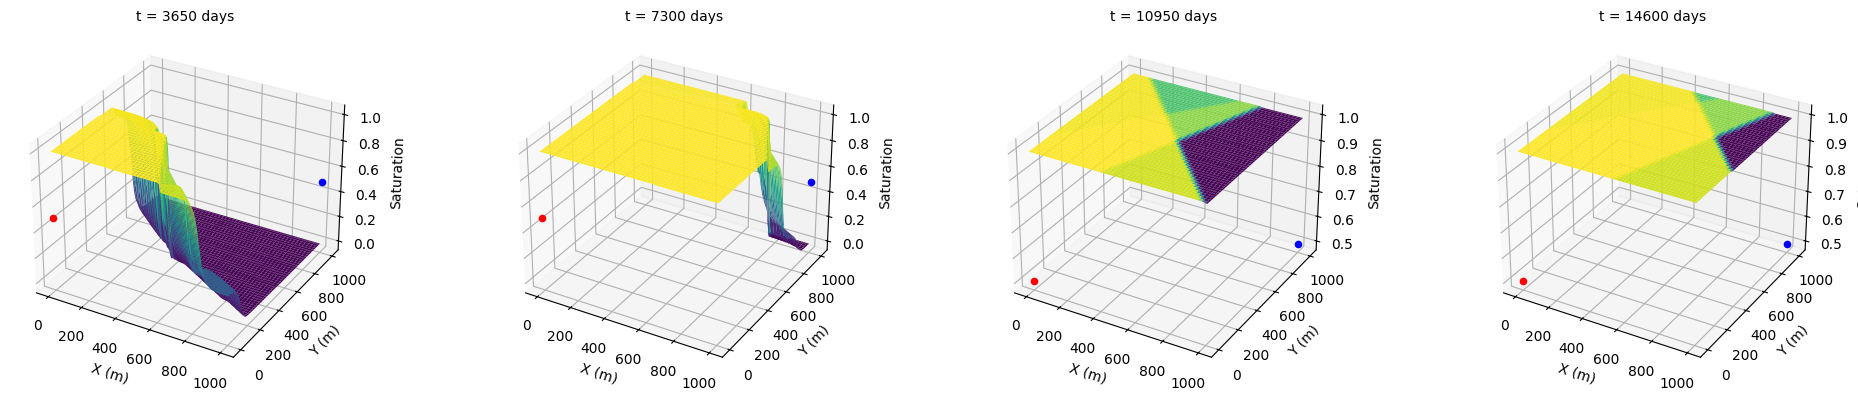

In [16]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

def visualize_3d_surface(model, times):
    x = np.linspace(0, L_x, 100)
    y = np.linspace(0, L_y, 100)
    X, Y = np.meshgrid(x, y)
    
    n_cols = 4  # 2 hình 1 hàng
    n_rows = int(np.ceil(len(times) / n_cols))  # Tính số hàng cần
    
    fig = plt.figure(figsize=(5*n_cols, 4*n_rows))  # Điều chỉnh size theo số lượng hình

    for idx, t in enumerate(times):
        points = np.vstack((X.flatten(), Y.flatten(), np.full_like(X.flatten(), t))).T
        Sw = model.predict(points)
        Sw = Sw.reshape(X.shape)
        
        ax = fig.add_subplot(n_rows, n_cols, idx+1, projection='3d')
        
        # Vẽ mặt nước bão hòa
        surf = ax.plot_surface(X, Y, Sw, cmap='viridis', edgecolor='none')
        
        # Đánh dấu vị trí Injection và Production wells
        ax.scatter(0, 0, 1/2, color='red', s=20)   # Injection (S_w = 1.0)
        ax.scatter(L_x, L_y, 1/2, color='blue', s=20) # Production (S_w = 0.0)
        
        ax.set_title(f't = {t} days', fontsize=10)
        ax.set_xlabel('X (m)')
        ax.set_ylabel('Y (m)')
        ax.set_zlabel('Saturation')

    # Điều chỉnh khoảng cách giữa các subplot
    plt.tight_layout()
    plt.show()

# Gọi hàm
times = [3650, 3650*2, 3650*3, 3650*4]  # Các thời điểm cần vẽ
visualize_3d_surface(model, times)

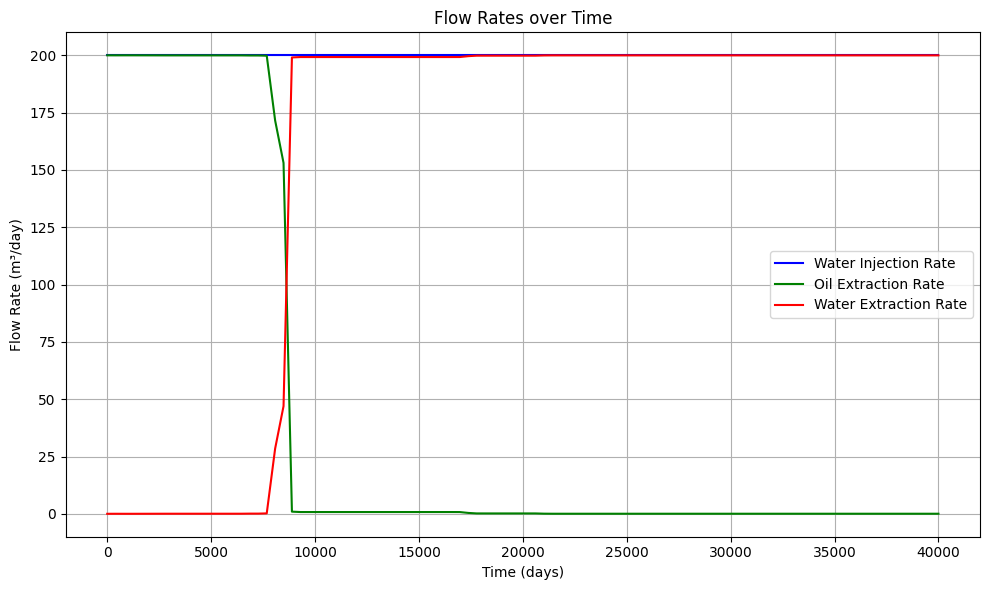

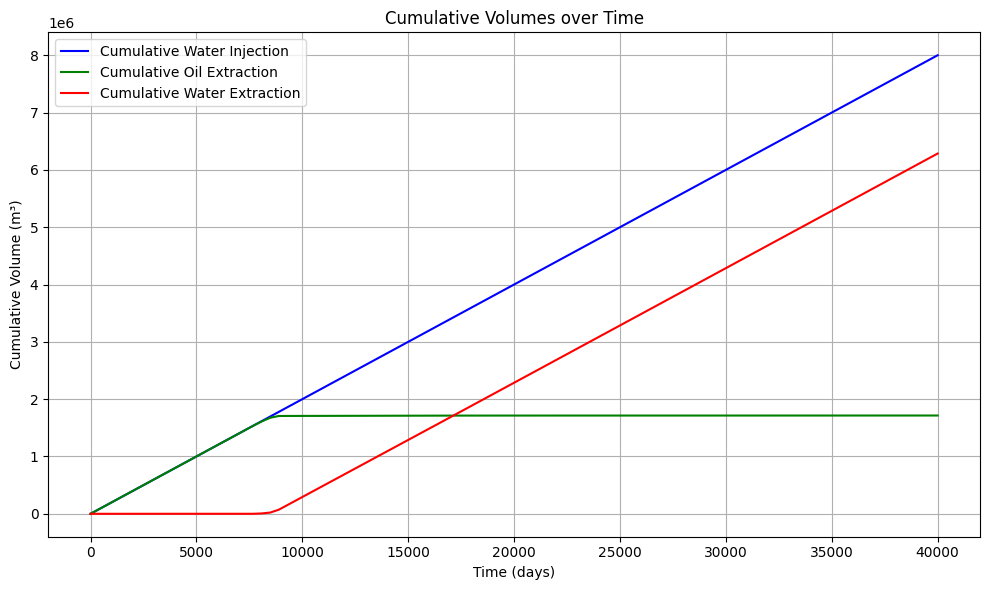

In [12]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import cumulative_trapezoid  # For numerical integration

# Modified function to include cumulative volumes
def calculate_flow_rates_and_volumes(model, time_points, production_loc=(L_x, L_y)):
    """
    Calculate flow rates and cumulative volumes at different time points.
    
    Parameters:
    - model: Trained DeepXDE model
    - time_points: Array of time points
    - production_loc: Location of production well
    """
    # Water injection rate is constant
    water_injection_rate = np.full_like(time_points, Q_w_inj)
    
    # Calculate water saturation at production well
    prod_points = np.array([[production_loc[0], production_loc[1], t] for t in time_points])
    water_saturation_prod = model.predict(prod_points).flatten()
    
    # Calculate oil and water extraction rates
    oil_extraction_rate = Q_prod * (1 - water_saturation_prod)
    water_extraction_rate = Q_prod * water_saturation_prod
    
    # Calculate cumulative volumes using numerical integration (trapezoidal rule)
    water_injection_volume = cumulative_trapezoid(water_injection_rate, time_points, initial=0)
    oil_extraction_volume = cumulative_trapezoid(oil_extraction_rate, time_points, initial=0)
    water_extraction_volume = cumulative_trapezoid(water_extraction_rate, time_points, initial=0)
    
    return {
        'time': time_points,
        'water_injection_rate': water_injection_rate,
        'oil_extraction_rate': oil_extraction_rate,
        'water_extraction_rate': water_extraction_rate,
        'water_injection_volume': water_injection_volume,
        'oil_extraction_volume': oil_extraction_volume,
        'water_extraction_volume': water_extraction_volume
    }

# New function to plot cumulative volumes
def plot_cumulative_volumes(flow_data):
    """
    Plot cumulative volumes over time.
    
    Parameters:
    - flow_data: Dictionary with flow rates and volumes
    """
    fig, ax = plt.subplots(figsize=(10, 6))
    
    ax.plot(flow_data['time'], flow_data['water_injection_volume'], 
            label='Cumulative Water Injection', color='blue')
    ax.plot(flow_data['time'], flow_data['oil_extraction_volume'], 
            label='Cumulative Oil Extraction', color='green')
    ax.plot(flow_data['time'], flow_data['water_extraction_volume'], 
            label='Cumulative Water Extraction', color='red')
    
    ax.set_xlabel('Time (days)')
    ax.set_ylabel('Cumulative Volume (m³)')
    ax.set_title('Cumulative Volumes over Time')
    ax.legend()
    ax.grid(True)
    
    plt.tight_layout()
    plt.show()
    
    return fig

# Modified original plot function (optional, if you still want both)
def plot_flow_rates(flow_data):
    """
    Plot flow rates over time.
    
    Parameters:
    - flow_data: Dictionary with flow rates and volumes
    """
    fig, ax = plt.subplots(figsize=(10, 6))
    
    ax.plot(flow_data['time'], flow_data['water_injection_rate'], 
            label='Water Injection Rate', color='blue')
    ax.plot(flow_data['time'], flow_data['oil_extraction_rate'], 
            label='Oil Extraction Rate', color='green')
    ax.plot(flow_data['time'], flow_data['water_extraction_rate'], 
            label='Water Extraction Rate', color='red')
    
    ax.set_xlabel('Time (days)')
    ax.set_ylabel('Flow Rate (m³/day)')
    ax.set_title('Flow Rates over Time')
    ax.legend()
    ax.grid(True)
    
    plt.tight_layout()
    plt.show()
    
    return fig

# Example usage
time_points = np.linspace(0, 40000, 100)
flow_data = calculate_flow_rates_and_volumes(model, time_points)

# Plot both flow rates and cumulative volumes
fig_flow_rates = plot_flow_rates(flow_data)
fig_cumulative_volumes = plot_cumulative_volumes(flow_data)

plt.close(fig_flow_rates)
plt.close(fig_cumulative_volumes)

In [13]:
# Figure 2: Dynamic 2D model over time (GIF)
def create_dynamic_2d_visualization(model, time_range, num_frames=1000, resolution=100):
    """
    Create an animated GIF of water saturation over time.
    
    Parameters:
    - model: Trained DeepXDE model
    - time_range: Tuple of (start_time, end_time)
    - num_frames: Number of frames in the animation
    - resolution: Number of points in each dimension
    """
    from matplotlib.animation import FuncAnimation
    
    # Create meshgrid for visualization
    x = np.linspace(0, L_x, resolution)
    y = np.linspace(0, L_y, resolution)
    X, Y = np.meshgrid(x, y)
    
    # Create figure
    fig, ax = plt.subplots(figsize=(8, 8))
    
    # Initialize plot
    start_time, end_time = time_range
    times = np.linspace(start_time, end_time, num_frames)
    
    # First frame data
    points = np.vstack([X.flatten(), Y.flatten(), np.full_like(X.flatten(), times[0])]).T
    Sw_pred = model.predict(points)
    Sw_2d = Sw_pred.reshape(resolution, resolution)
    
    # Create plot
    im = ax.imshow(Sw_2d, origin='lower', extent=[0, L_x, 0, L_y], 
                   vmin=0, vmax=1, cmap='jet', animated=True)
    
    # Add colorbar
    cbar = fig.colorbar(im, ax=ax, label="Water Saturation")
    
    # Add labels
    ax.set_xlabel("X (m)")
    ax.set_ylabel("Y (m)")
    title = ax.set_title(f"Time = {times[0]:.1f} days")
    
    def update(frame):
        """Update function for animation."""
        # Update title
        title.set_text(f"Time = {times[frame]:.1f} days")
        
        # Update data
        points = np.vstack([X.flatten(), Y.flatten(), np.full_like(X.flatten(), times[frame])]).T
        Sw_pred = model.predict(points)
        Sw_2d = Sw_pred.reshape(resolution, resolution)
        
        # Update image
        im.set_array(Sw_2d)
        return [im, title]
    
    # Create animation
    anim = FuncAnimation(fig, update, frames=num_frames, blit=True)
    
    # Save animation as GIF
    anim.save("water_saturation_2d_20000.gif", writer='pillow', fps=10, dpi=100)
    
    plt.close(fig)
    
    print("Animation saved as 'water_saturation_2d_20000.gif'")

# Example usage
dynamic_time_range = (0, 15000)
create_dynamic_2d_visualization(model, dynamic_time_range)


Animation saved as 'water_saturation_2d_20000.gif'


In [14]:
import numpy as np
import matplotlib.pyplot as plt
import imageio
import os

# Tham số
L_x, L_y = 1000, 1000  # Kích thước vỉa (m) - from your previous code
nx, ny = 20, 20  # Số điểm lưới
x = np.linspace(0, L_x, nx)
y = np.linspace(0, L_y, ny)
X, Y = np.meshgrid(x, y)
num_frames = 300
time_points = np.linspace(0, 20000, num_frames)  # Thời gian mô phỏng (days)

# Hàm dự đoán độ bão hòa nước trên lưới 2D tại một thời điểm nhất định
def get_water_saturation(model, X, Y, t):
    # Chuyển lưới 2D thành danh sách các điểm với thời gian
    points = np.vstack((X.flatten(), Y.flatten(), np.full(X.size, t))).T
    Sw = model.predict(points).reshape(X.shape)
    # Giới hạn Sw trong khoảng [0, 1] để đảm bảo tính vật lý
    Sw = np.clip(Sw, 0, 1)
    return Sw

# Hàm tạo khung hình cho mặt cắt 2D
def create_frame(Sw, t, frame_idx):
    fig, ax = plt.subplots(figsize=(8, 6))
    c = ax.contourf(X, Y, Sw, cmap='RdBu_r', vmin=0, vmax=1)
    plt.colorbar(c, ax=ax, label='Water Saturation (Sw)')
    ax.plot([0], [0], 'ro', label='Injection Well (x=0, y=0)')
    ax.plot([L_x], [L_y], 'go', label='Production Well (x=L_x, y=L_y)')
    ax.legend()
    ax.set_xlabel('X (m)')
    ax.set_ylabel('Y (m)')
    ax.set_title(f'Water Saturation at t = {t:.0f} days')
    filename = f'frame_{frame_idx:03d}.png'
    plt.savefig(filename, dpi=100, bbox_inches='tight')
    plt.close(fig)
    return filename

# Tạo các khung hình
frames = []
for i, t in enumerate(time_points):
    print(f"Đang tạo khung hình {i+1}/{num_frames}")
    Sw = get_water_saturation(model, X, Y, t)
    frame_file = create_frame(Sw, t, i)
    frames.append(frame_file)

# Tạo GIF
gif_filename = 'reservoir_sw_simulation_2d.gif'
with imageio.get_writer(gif_filename, mode='I', duration=0.5) as writer:
    for frame in frames:
        image = imageio.imread(frame)
        writer.append_data(image)
        os.remove(frame)  # Xóa file khung hình tạm thời

print(f"GIF đã được lưu dưới tên {gif_filename}")

Đang tạo khung hình 1/300
Đang tạo khung hình 2/300
Đang tạo khung hình 3/300
Đang tạo khung hình 4/300
Đang tạo khung hình 5/300
Đang tạo khung hình 6/300
Đang tạo khung hình 7/300
Đang tạo khung hình 8/300
Đang tạo khung hình 9/300
Đang tạo khung hình 10/300
Đang tạo khung hình 11/300
Đang tạo khung hình 12/300
Đang tạo khung hình 13/300
Đang tạo khung hình 14/300
Đang tạo khung hình 15/300
Đang tạo khung hình 16/300
Đang tạo khung hình 17/300
Đang tạo khung hình 18/300
Đang tạo khung hình 19/300
Đang tạo khung hình 20/300
Đang tạo khung hình 21/300
Đang tạo khung hình 22/300
Đang tạo khung hình 23/300
Đang tạo khung hình 24/300
Đang tạo khung hình 25/300
Đang tạo khung hình 26/300
Đang tạo khung hình 27/300
Đang tạo khung hình 28/300
Đang tạo khung hình 29/300
Đang tạo khung hình 30/300
Đang tạo khung hình 31/300
Đang tạo khung hình 32/300
Đang tạo khung hình 33/300
Đang tạo khung hình 34/300
Đang tạo khung hình 35/300
Đang tạo khung hình 36/300
Đang tạo khung hình 37/300
Đang tạo k

C:\Users\User\AppData\Local\Temp\ipykernel_23248\1916998693.py:52: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(frame)


GIF đã được lưu dưới tên reservoir_sw_simulation_2d.gif
